# Trafficsigns Detection

In [163]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from textwrap import wrap
from skimage import exposure, color

In [93]:
from google.colab import drive
drive.mount('/content/drive')
base_path='/content/drive/MyDrive/neural_networks_1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading Data

In [94]:
label_names = pd.read_csv(base_path+'/label_names.csv')
label_names.set_index('ClassId',inplace=True)

In [95]:
with open(base_path+'/train.pickle','rb') as train_file, \
  open(base_path+'/valid.pickle','rb') as validation_file, \
  open(base_path+'/test.pickle','rb') as test_file:
  train = pickle.load(train_file)
  validation = pickle.load(validation_file)
  test = pickle.load(test_file)

In [96]:
print(train['features'].shape)
print(validation['features'].shape)
print(test['features'].shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [97]:
x_trn, y_trn = train['features'], train['labels']
x_val, y_val = validation['features'], validation['labels']
x_tst, y_tst = test['features'], test['labels']

# Visualizing Data
## label names

In [98]:
label_names.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


## Balance of classes

In [99]:
#balace of classes
def show_class_balances(y,ax,name):
  index, counts = np.unique(y,return_counts=True)
  df = pd.DataFrame({'name':label_names['SignName'],'data_count':counts},index=index)
  plot = sns.barplot(y='name',x='data_count',data=df,ax=ax)
  plot.set_ylabel('class name')
  plot.set_xlabel(f'data count({name})')

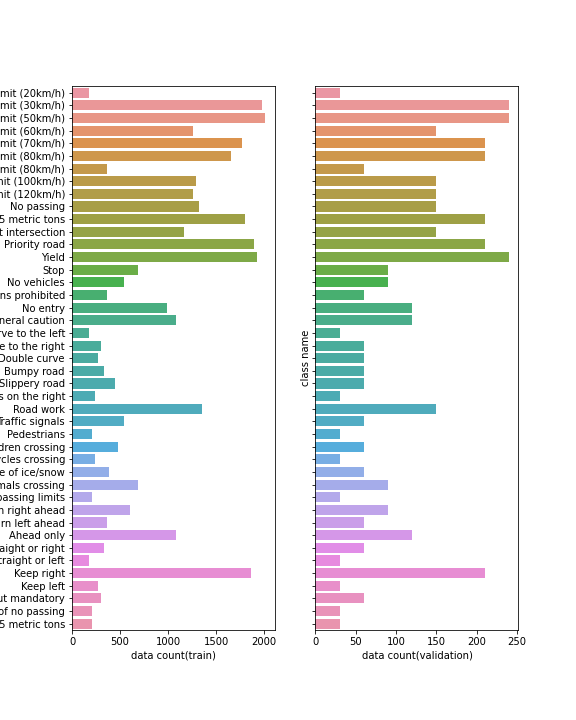

In [100]:
fig , ax = plt.subplots(nrows=1,ncols=2,figsize=(8,10),sharey=True)
show_class_balances(y_trn,ax[0],'train')
show_class_balances(y_val,ax[1],'validation')

we see that classes are unbalaced, downsampling decreses computational power needed to train this network, but least data count between classes in train data is about 100 and it's probably not enough for image data so we upsample them

## A sample of each class

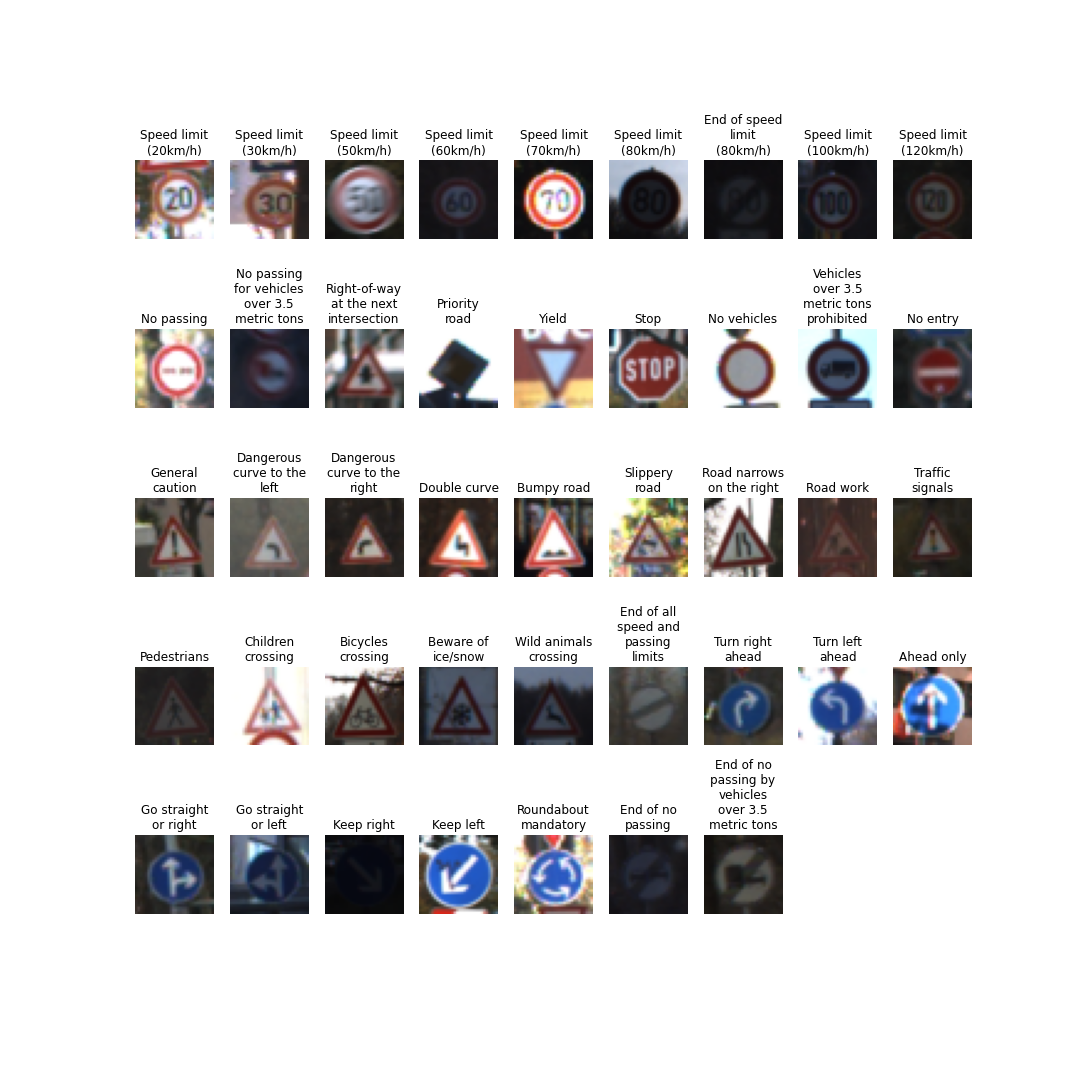

In [101]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
fig, ax = plt.subplots(nrows=5 , ncols=9,figsize=(15,15))
sample_picture_indices= [np.random.choice(np.nonzero(y_trn == i)[0],size=1)[0] for i in range(len(label_names))]
for i in range(5):
  for j in range(9):
    if 9*i + j <= 42:
      ax[i,j].imshow(x_trn[sample_picture_indices[9*i+j]])
      ax[i,j].set_title('\n'.join(wrap(label_names['SignName'][9*i+j],12)))
    ax[i,j].axis('off')
      

## Multiple Samples for a class

In [102]:
def show_class_samples(label_index,count=5):
  fig, ax = plt.subplots(nrows=1,ncols=count,sharey=True)
  sample_picture_indices = np.random.choice(np.nonzero(y_trn == label_index)[0],size=count)
  for i in range(count):
    ax[i].imshow(x_trn[sample_picture_indices[i]])
    ax[i].axis('off')
  plt.suptitle(f"samples of `{label_names['SignName'][label_index]}` in training set")

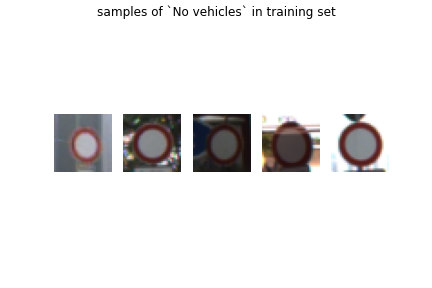

In [103]:
show_class_samples(15)

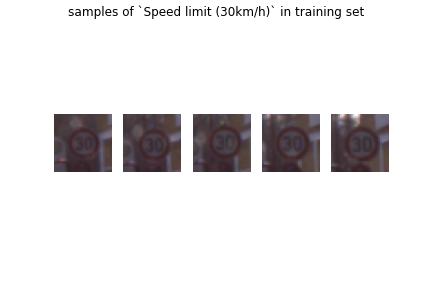

In [104]:
def show_nonrandom_samples(label_index,count=5):
  fig, ax = plt.subplots(nrows=1,ncols=count,sharey=True)
  sample_picture_indices = np.nonzero(y_trn == label_index)[0][0:count]
  for i in range(count):
    ax[i].imshow(x_trn[sample_picture_indices[i]])
    ax[i].axis('off')
  plt.suptitle(f"samples of `{label_names['SignName'][label_index]}` in training set")
show_nonrandom_samples(1)

we see that this data is previously augmented.

# Preprocessing Data
here we process data in order to feed it to out neural network

In [105]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation , Concatenate, Input , BatchNormalization,Lambda
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import activations

In [106]:
#one-hot encode target variables
y_trn_cat = to_categorical(y_trn)
y_val_cat = to_categorical(y_val)
y_tst_cat = to_categorical(y_tst)

## Data Generator
here we:
- augment out and validation data by applying rotation, zoom and width shit to images
- test to apply normalization (standard scaling) to our images
- grayscale our images to see if our neural network can detect trafficsigns only depending on their shape (we implement this by adding a `Lambda` layer after input layer of the model)

In [107]:
BATCH_SIZE = 128
datagen_trn = ImageDataGenerator(
        featurewise_std_normalization=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        validation_split=0)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [108]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

## Random Upsampling
we have defined balanced data generator in order to balance target classes and augment our data in one place

In [109]:
balanced_datagen = BalancedDataGenerator(x_trn,y_trn_cat,datagen_trn,batch_size=BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [110]:
grayscale_layer = Lambda(lambda x:rgb_to_grayscale(x))

## Early Stopping
this makes training stop when validation loss decreases after 1 epoch

In [111]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

## Model Checkpoint
saving best weights of the model to `/weights.hd5` 

In [112]:
checkpointer = ModelCheckpoint(filepath=base_path+'/baseline_weights.hdf5', 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

## Enabling `Reduce on Plateu`
this decreases learning rate and waits some epochs after decreasing learning rate to see it's impact

In [113]:
lrr= ReduceLROnPlateau(monitor='val_accuracy', 
                       factor=.01, 
                       patience=5, 
                       min_lr=1e-5)

# Defining Model
first we define our baseline model, then we define other models with subtle changes and at last we monitor all of them in order to decide between

## Baseline model


In [114]:
input_model = Input((x_trn.shape[1],x_trn.shape[2],x_trn.shape[3]),name = 'input_layer')

model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_5')(input_model)
model1 = BatchNormalization(name = 'Bnorm1')(model1)
model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv2_5')(model1)
model1 = BatchNormalization(name = 'Bnorm2')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv3_3')(model1)
model1 = BatchNormalization(name = 'Bnorm3')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv4_3')(model1)
model1 = BatchNormalization(name = 'Bnorm4')(model1)
model1 = AveragePooling2D((2, 2),name = 'AvgPool1')(model1)
model1 = Conv2D(128,(1,1), activation='relu' ,padding='valid',name = 'Conv5_1')(model1)
model1 = BatchNormalization(name = 'Bnorm5')(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
model1 = Dense(units = 32, activation = 'relu')(model1)
model1 = Dropout(rate = 0.2)(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units = 20, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units = 15, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
output = Dense(units = 43, activation = 'softmax' , name='preds')(model1)

baseline_model = Model(inputs= [input_model], outputs=[output])
baseline_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
Conv1_5 (Conv2D)             (None, 28, 28, 32)        2432      
_________________________________________________________________
Bnorm1 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
Conv2_5 (Conv2D)             (None, 28, 28, 32)        25632     
_________________________________________________________________
Bnorm2 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
_________________________________________________________________
Conv3_3 (Conv2D)             (None, 14, 14, 64)       

### Plot baseline model

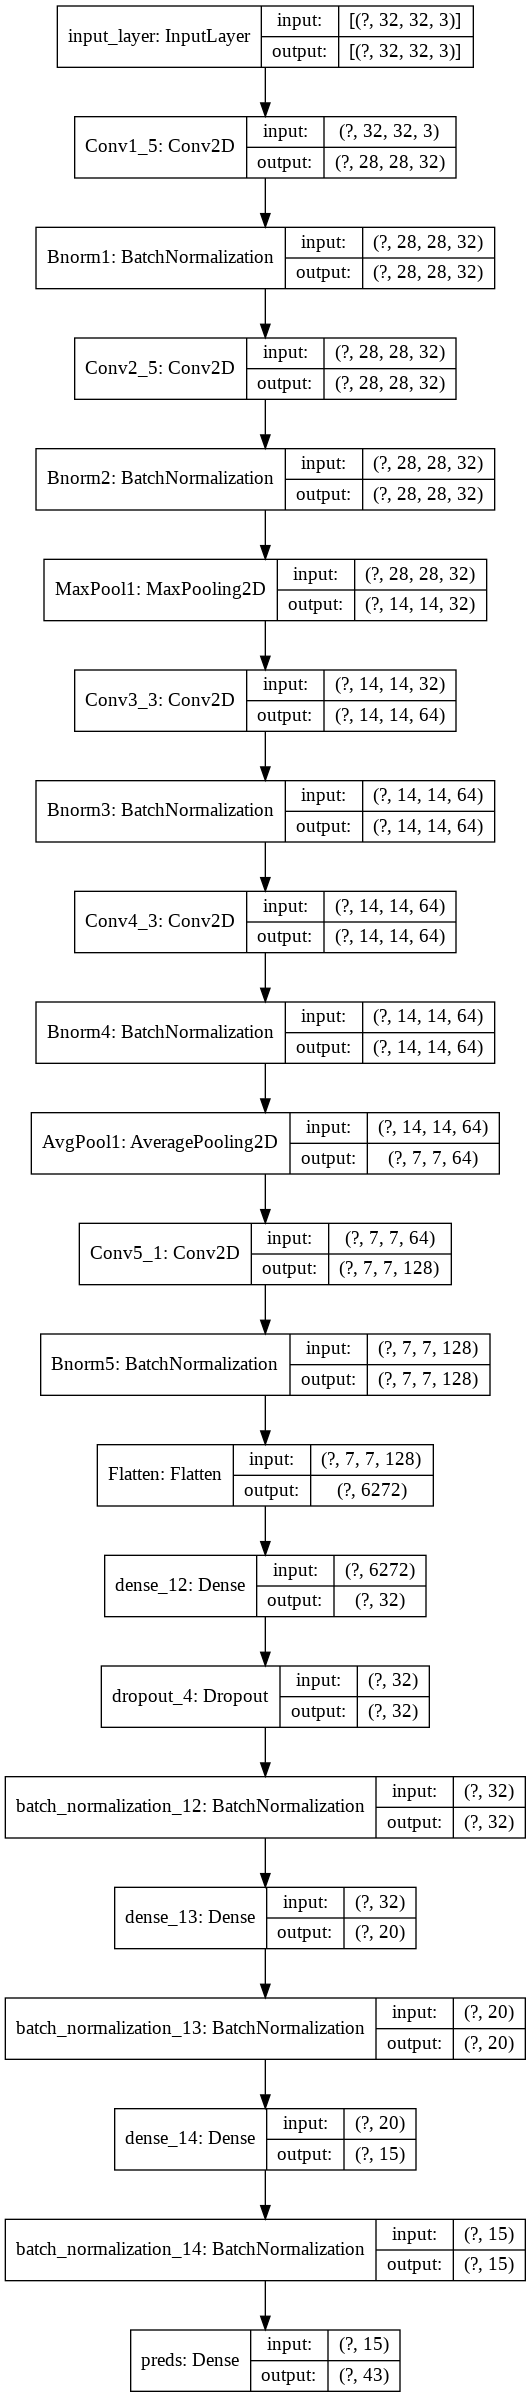

In [115]:
plot_model(baseline_model, show_shapes=True,to_file=base_path+'/baseline_model.png')

In [116]:
# we use `adam` for optimization, its more efficient than gradiant decend
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
#old data generators
# data_trn = datagen_trn.flow(x_trn,y=y_trn_cat,batch_size = BATCH_SIZE)
# data_val = datagen_tst.flow(x_val,y=y_val_cat,batch_size = BATCH_SIZE)

In [118]:
baseline_history = baseline_model.fit_generator(balanced_datagen, 
                              epochs= 50,
                              validation_data= (x_val,y_val_cat),
                              verbose=1,
                              callbacks=[es , checkpointer, lrr])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/50
674/675 [============================>.] - ETA: 0s - loss: 1.8815 - accuracy: 0.5070
Epoch 00001: val_accuracy improved from -inf to 0.80408, saving model to /content/drive/MyDrive/neural_networks_1/baseline_weights.hdf5
675/675 [==============================] - 38s 56ms/step - loss: 1.8811 - accuracy: 0.5071 - val_loss: 0.7468 - val_accuracy: 0.8041
Epoch 2/50
675/675 [==============================] - ETA: 0s - loss: 0.3921 - accuracy: 0.9010
Epoch 00002: val_accuracy improved from 0.80408 to 0.94286, saving model to /content/drive/MyDrive/neural_networks_1/baseline_weights.hdf5
675/675 [==============================] - 40s 59ms/step - loss: 0.3921 - accuracy: 0.9010 - val_loss: 0.1966 - val_accuracy: 0.9429
Epoch 3/50
675/675 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9579
Epoch 00003: val_accuracy improved from 0.94286 to 0.97506, saving model to /content/drive/MyDrive/neural_networks_1/baseline_weights.hdf5
675/675 [=======================

### Monitor baseline model

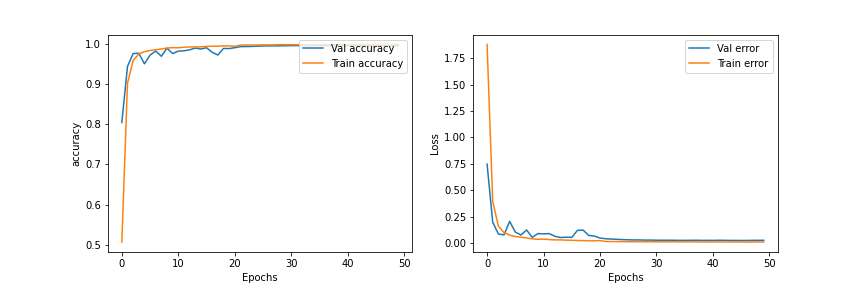

In [119]:
def monitor_model(model_history,file_path):
  val_accuracy = model_history.history['val_accuracy']
  accuracy = model_history.history['accuracy']
  fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
  ax[0].plot(val_accuracy)
  ax[0].plot(accuracy)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend(['Val accuracy','Train accuracy'], loc='upper right')

  val_loss = model_history.history['val_loss']
  loss = model_history.history['loss']
  ax[1].plot(val_loss)
  ax[1].plot(loss)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend(['Val error','Train error'], loc='upper right')
  plt.savefig(file_path)
  plt.show()

monitor_model(baseline_history,base_path+'/baseline_model_1.png')

### Overfit or not
case of .99 accuray of validation and train, maybe overfit has occured
so we calculate accuracy for the test data

In [120]:
baseline_model.evaluate(x_tst,y_tst_cat,batch_size=BATCH_SIZE)

99/99 [==============================] - 0s 4ms/step - loss: 0.1174 - accuracy: 0.9804


[0.11744295060634613, 0.980364203453064]

it works fine on the test data so everythings fine

## Grayscale model
we train the previous baseline model with `grayscale_layer` lambda (that we have defined earlier) added after input layer to train out model with grayscale images

In [121]:
input_model = Input((x_trn.shape[1],x_trn.shape[2],x_trn.shape[3]),name = 'input_layer')

model2 = grayscale_layer(input_model)
model2 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_5')(model2)
model2 = BatchNormalization(name = 'Bnorm1')(model2)
model2 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv2_5')(model2)
model2 = BatchNormalization(name = 'Bnorm2')(model2)
model2 = MaxPooling2D((2, 2),name = 'MaxPool1')(model2)
model2 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv3_3')(model2)
model2 = BatchNormalization(name = 'Bnorm3')(model2)
model2 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv4_3')(model2)
model2 = BatchNormalization(name = 'Bnorm4')(model2)
model2 = AveragePooling2D((2, 2),name = 'AvgPool1')(model2)
model2 = Conv2D(128,(1,1), activation='relu' ,padding='valid',name = 'Conv5_1')(model2)
model2 = BatchNormalization(name = 'Bnorm5')(model2)
########################################################
model2 = Flatten(name = 'Flatten')(model2)
########################################################
model2 = Dense(units = 32, activation = 'relu')(model2)
model2 = Dropout(rate = 0.2)(model2)
model2 = BatchNormalization()(model2)
model2 = Dense(units = 20, activation = 'relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dense(units = 15, activation = 'relu')(model2)
model2 = BatchNormalization()(model2)
output = Dense(units = 43, activation = 'softmax' , name='preds')(model2)

grayscale_model = Model(inputs= [input_model], outputs=[output])
grayscale_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
Conv1_5 (Conv2D)             (None, 28, 28, 32)        832       
_________________________________________________________________
Bnorm1 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
Conv2_5 (Conv2D)             (None, 28, 28, 32)        25632     
_________________________________________________________________
Bnorm2 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 32)      

In [122]:
checkpointer_grayscale = ModelCheckpoint(filepath=base_path+'/grayscale_model_weights.hdf5', 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

### Plot grayscale model

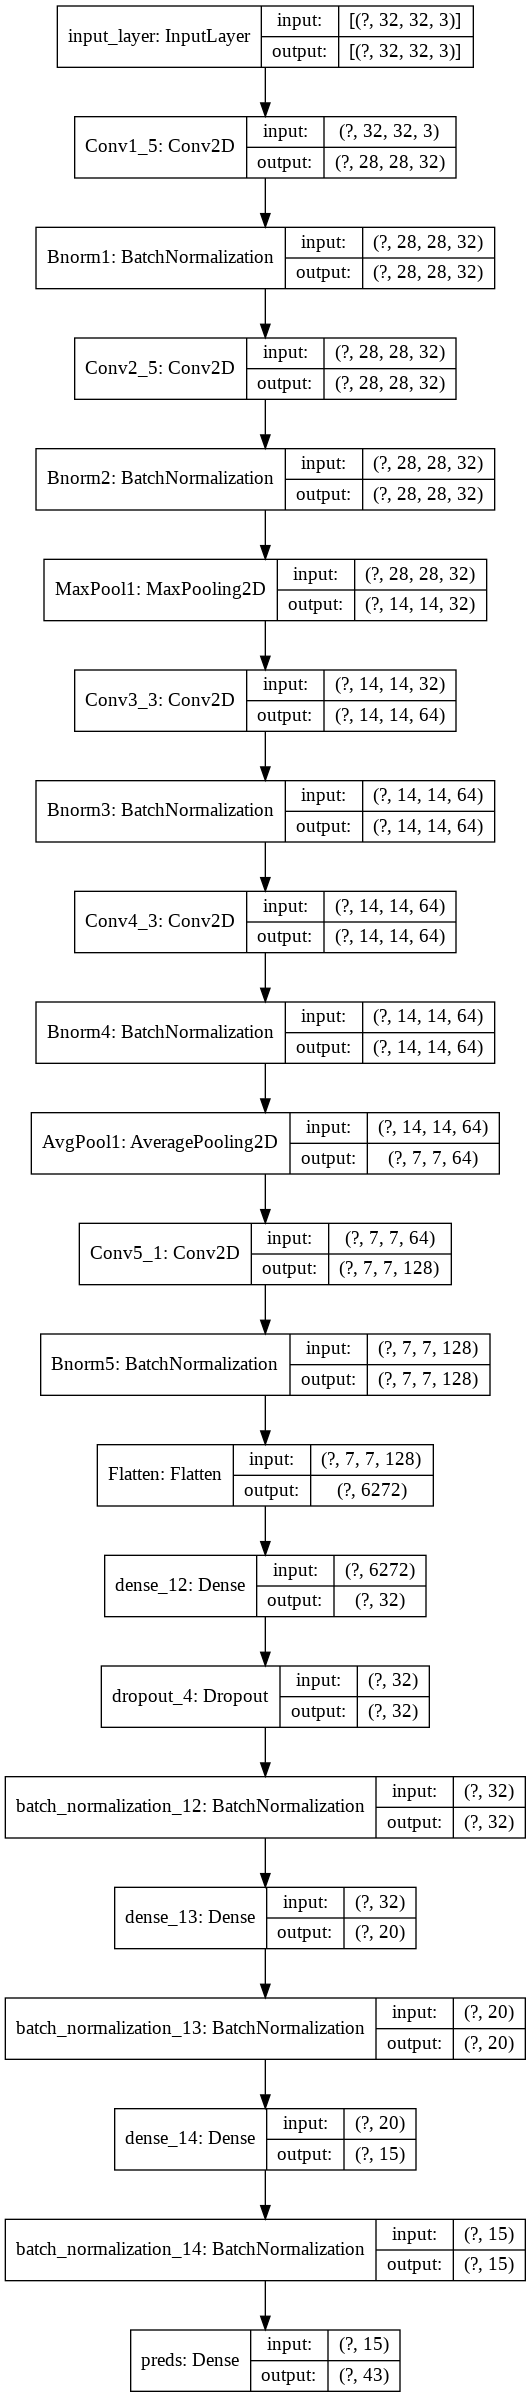

In [123]:
plot_model(grayscle_model, show_shapes=True,to_file=base_path+'/grayscale_model.png')

In [124]:
grayscale_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [125]:
grayscale_model_history = grayscale_model.fit_generator(balanced_datagen, 
                              epochs= 50,
                              validation_data= (x_val,y_val_cat),
                              verbose=1,
                              callbacks=[es , checkpointer_grayscale, lrr])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/50
675/675 [==============================] - ETA: 0s - loss: 1.9142 - accuracy: 0.5183
Epoch 00001: val_accuracy improved from -inf to 0.87823, saving model to /content/drive/MyDrive/neural_networks_1/grayscale_model_weights.hdf5
675/675 [==============================] - 40s 59ms/step - loss: 1.9142 - accuracy: 0.5183 - val_loss: 0.5251 - val_accuracy: 0.8782
Epoch 2/50
675/675 [==============================] - ETA: 0s - loss: 0.3397 - accuracy: 0.9195
Epoch 00002: val_accuracy improved from 0.87823 to 0.97506, saving model to /content/drive/MyDrive/neural_networks_1/grayscale_model_weights.hdf5
675/675 [==============================] - 40s 60ms/step - loss: 0.3397 - accuracy: 0.9195 - val_loss: 0.1045 - val_accuracy: 0.9751
Epoch 3/50
675/675 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9660
Epoch 00003: val_accuracy did not improve from 0.97506
675/675 [==============================] - 39s 58ms/step - loss: 0.1379 - accuracy: 0.9660 - val_loss:

### Monitor grayscale model

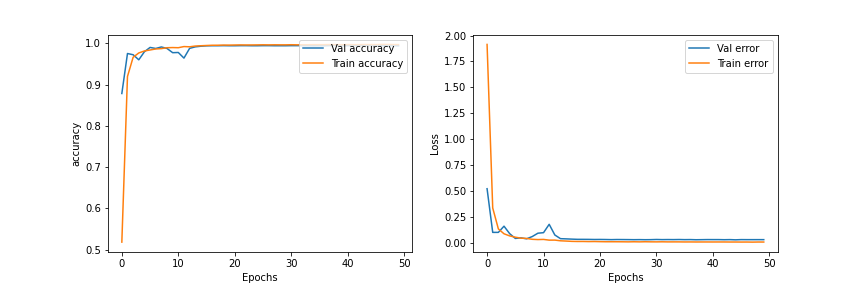

In [126]:
monitor_model(grayscale_model_history,base_path+'/grayscale_model.png')

In [127]:
grayscale_model.evaluate(x_tst,y_tst_cat,batch_size=BATCH_SIZE)

99/99 [==============================] - 0s 4ms/step - loss: 0.1285 - accuracy: 0.9781


[0.12850768864154816, 0.9781472682952881]

it has almost the same accuracy on the train and test set, but maybe for further investigation, we should calculate precision,recall and f1-score for these models

## Histogram equalization

In [155]:
def show_nonrandom_histograms(label_index,count=5):
  fig, ax = plt.subplots(nrows=3,ncols=count,sharey=True,figsize=(3*count,6))
  sample_picture_indices = np.nonzero(y_trn == label_index)[0][0:count]
  for i in range(count):
    ax[0,i].hist(x_trn[sample_picture_indices[i]][:,:,0])
    ax[0,i].set_xlim([0,255])
    ax[0,i].set_ylabel('red')
    ax[1,i].hist(x_trn[sample_picture_indices[i]][:,:,1])
    ax[1,i].set_xlim([0,255])
    ax[1,i].set_ylabel('green')
    ax[2,i].hist(x_trn[sample_picture_indices[i]][:,:,2])
    ax[2,i].set_xlim([0,255])
    ax[2,i].set_ylabel('blue')
  plt.suptitle(f"histogram for samples of `{label_names['SignName'][label_index]}` in training set")

### plotting some histograms

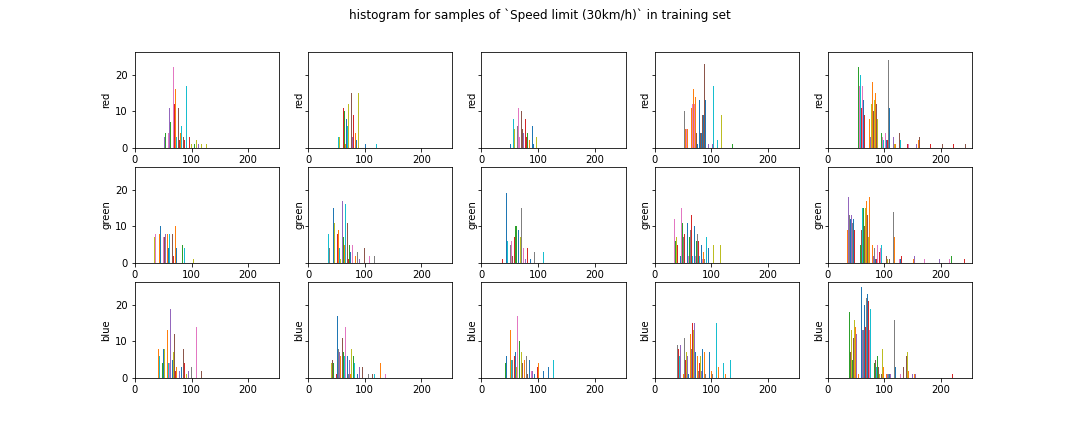

In [156]:
show_nonrandom_histograms(1)

### Equalizing histograms
in the plot we have seen that histograms are skewed and we better equalize out histograms

for this purpose we use `Histogram Equalization` in `ImageDataGenerator` especially Adaptive equalization

In [190]:
def adaptive_histogram_equalization(image):
  return exposure.equalize_adapthist(image/255,clip_limit=0.03)*255

def histogram_equalization(image):
  return exposure.equalize_histogram(image/255)*255

In [191]:
datagen_equalized = ImageDataGenerator(
        featurewise_std_normalization=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        validation_split=0,
        data_format=K.image_data_format(),
        preprocessing_function=histogram_equalization)

In [192]:
datagen_adaptive.fit(x_trn)

In [193]:
#HE stands for historgram equalized
balanced_datagen_HE = BalancedDataGenerator(x_trn,y_trn_cat,datagen_adaptive,batch_size=BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Retrain Model
now we retrain our model with equalized histograms.

In [194]:
checkpointer_HE = ModelCheckpoint(filepath=base_path+'/HE_weights.hdf5', 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

In [196]:
baseline_history_HE = baseline_model.fit_generator(balanced_datagen_HE, 
                              epochs= 3,
                              validation_data= (x_val,y_val_cat),
                              verbose=1,
                              callbacks=[es , checkpointer_HE, lrr])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/3
675/675 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9548
Epoch 00001: val_accuracy improved from -inf to 0.89274, saving model to /content/drive/MyDrive/neural_networks_1/HE_weights.hdf5
675/675 [==============================] - 850s 1s/step - loss: 0.2131 - accuracy: 0.9548 - val_loss: 0.6945 - val_accuracy: 0.8927
Epoch 2/3
675/675 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.9606
Epoch 00002: val_accuracy did not improve from 0.89274
675/675 [==============================] - 882s 1s/step - loss: 0.1777 - accuracy: 0.9606 - val_loss: 0.8001 - val_accuracy: 0.8828
Epoch 3/3
675/675 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9652
Epoch 00003: val_accuracy did not improve from 0.89274
675/675 [==============================] - 842s 1s/step - loss: 0.1503 - accuracy: 0.9652 - val_loss: 0.9006 - val_accuracy: 0.8719


cause of using histogram equalization preprocessing+training process is so slow, thus we only train our model with equalized histograms for 3 epochs

# Visualizing ouput of network layers
plotting output for grayscale model layers

In [205]:
layer_names = [layer.name for layer in grayscale_model.layers]
print("Layers:")
layer_names

Layers:


['input_layer',
 'lambda_3',
 'Conv1_5',
 'Bnorm1',
 'Conv2_5',
 'Bnorm2',
 'MaxPool1',
 'Conv3_3',
 'Bnorm3',
 'Conv4_3',
 'Bnorm4',
 'AvgPool1',
 'Conv5_1',
 'Bnorm5',
 'Flatten',
 'dense_15',
 'dropout_5',
 'batch_normalization_15',
 'dense_16',
 'batch_normalization_16',
 'dense_17',
 'batch_normalization_17',
 'preds']

## Output of Convolutional layers

layer : lambda_3 , feature map shape : (1, 32, 32, 1)
nrow : 0 , ncol : 8


<Figure size 1440x1080 with 0 Axes>

layer : Conv1_5 , feature map shape : (1, 28, 28, 32)
nrow : 4 , ncol : 8


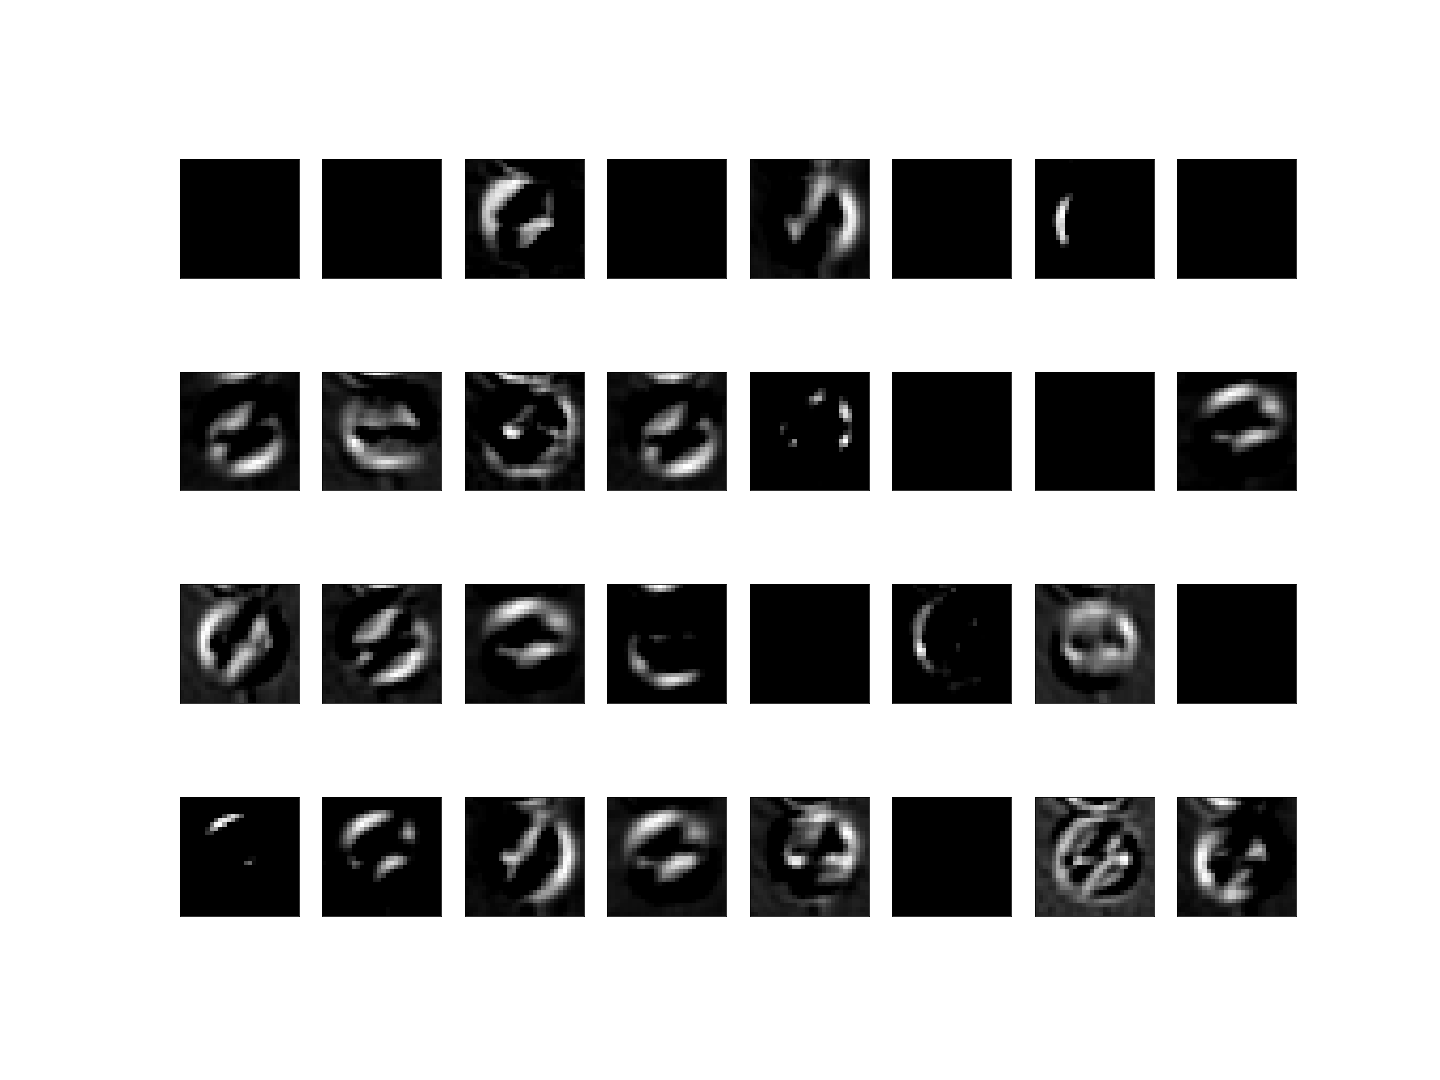

layer : Bnorm1 , feature map shape : (1, 28, 28, 32)
nrow : 4 , ncol : 8


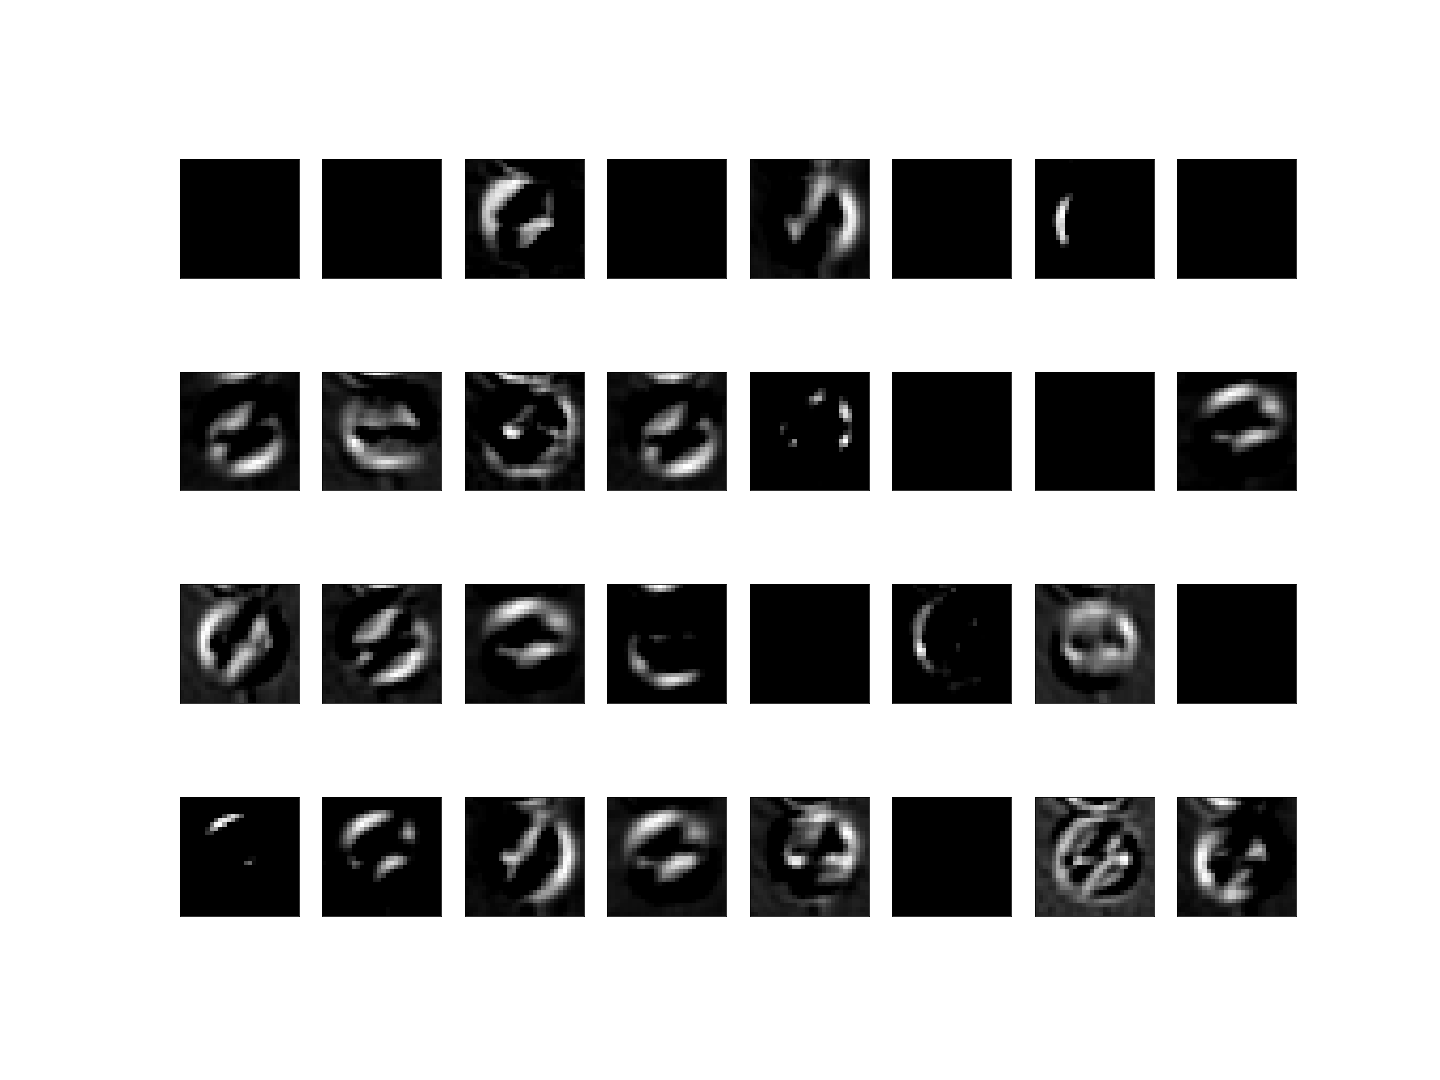

layer : Conv2_5 , feature map shape : (1, 28, 28, 32)
nrow : 4 , ncol : 8


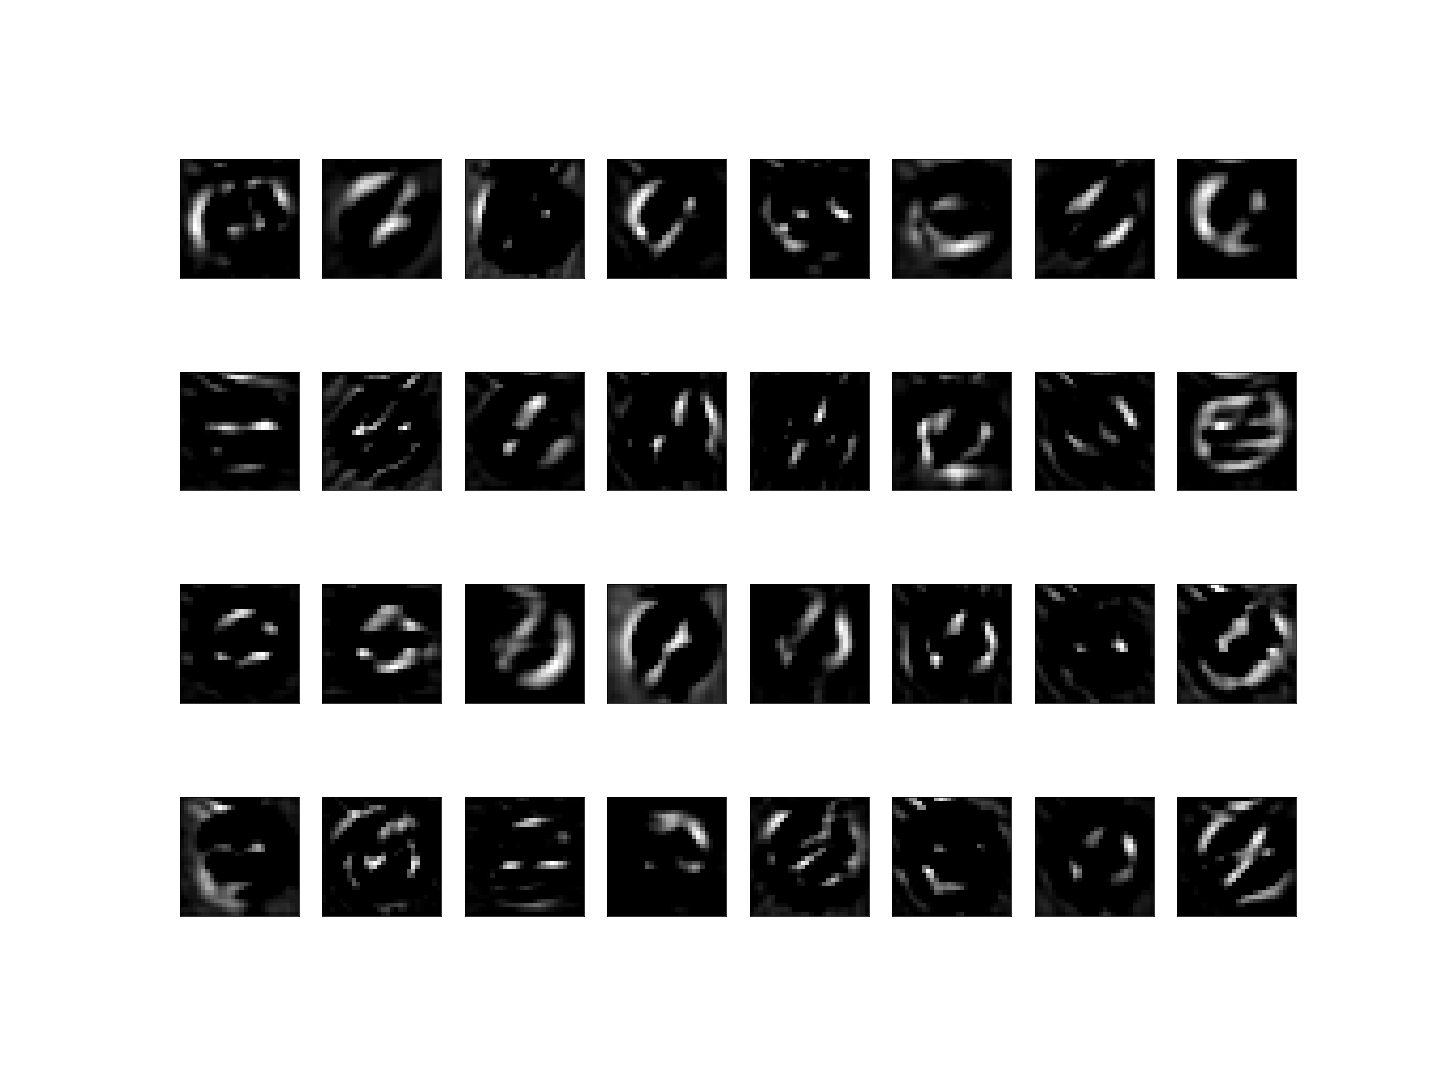

layer : Bnorm2 , feature map shape : (1, 28, 28, 32)
nrow : 4 , ncol : 8


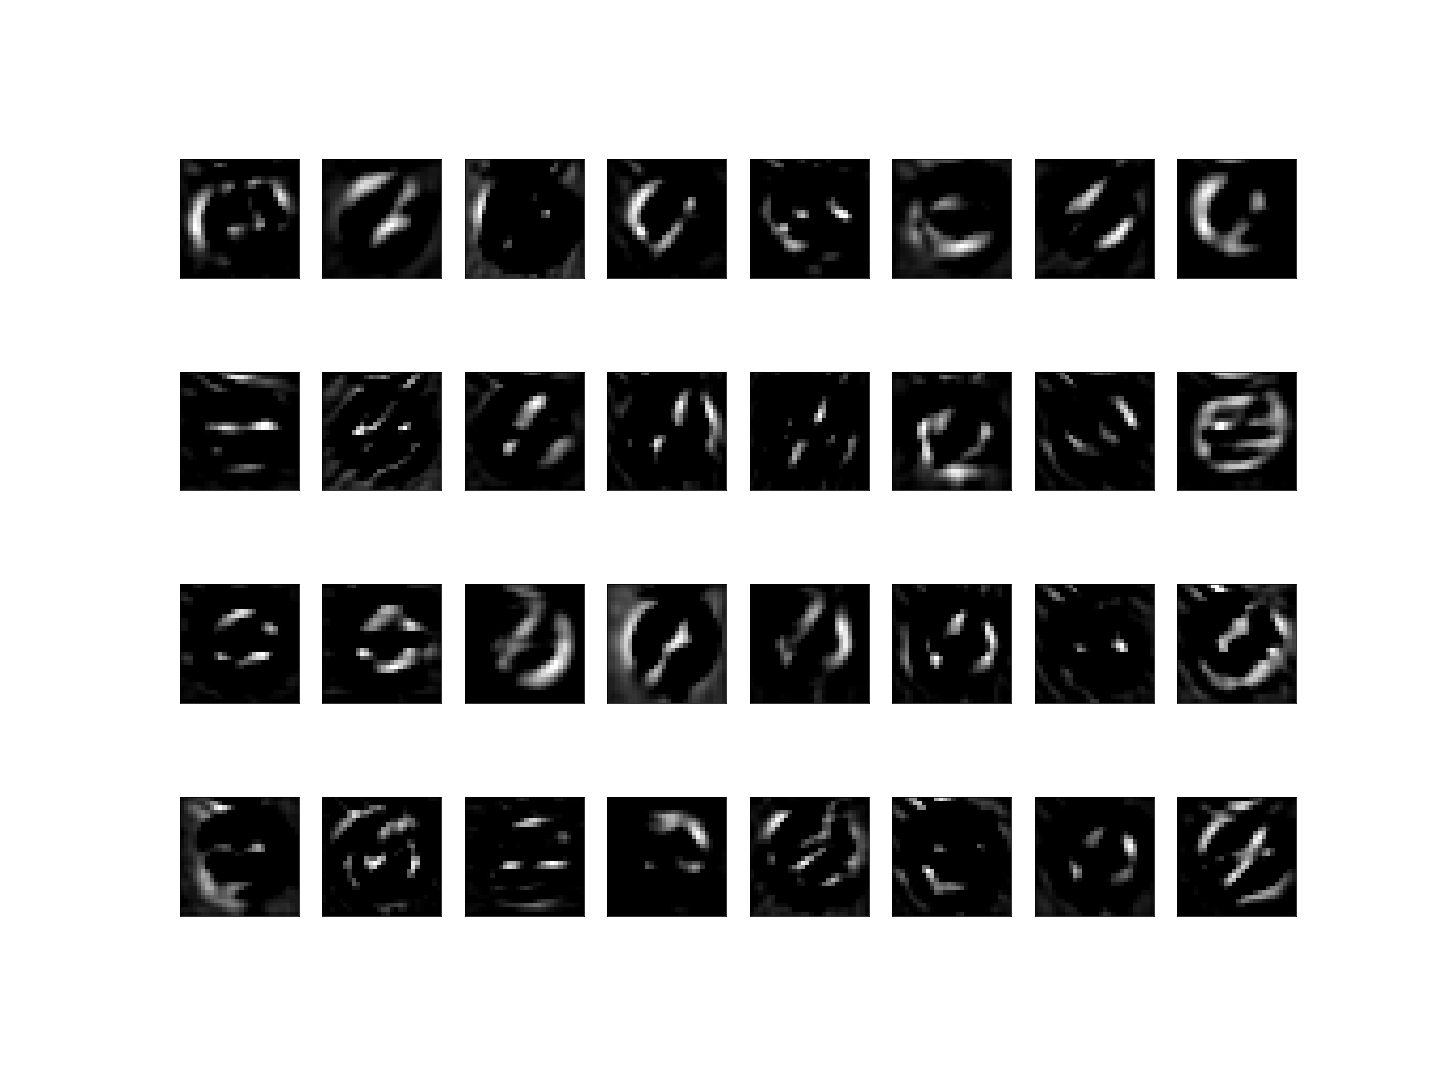

layer : MaxPool1 , feature map shape : (1, 14, 14, 32)
nrow : 4 , ncol : 8


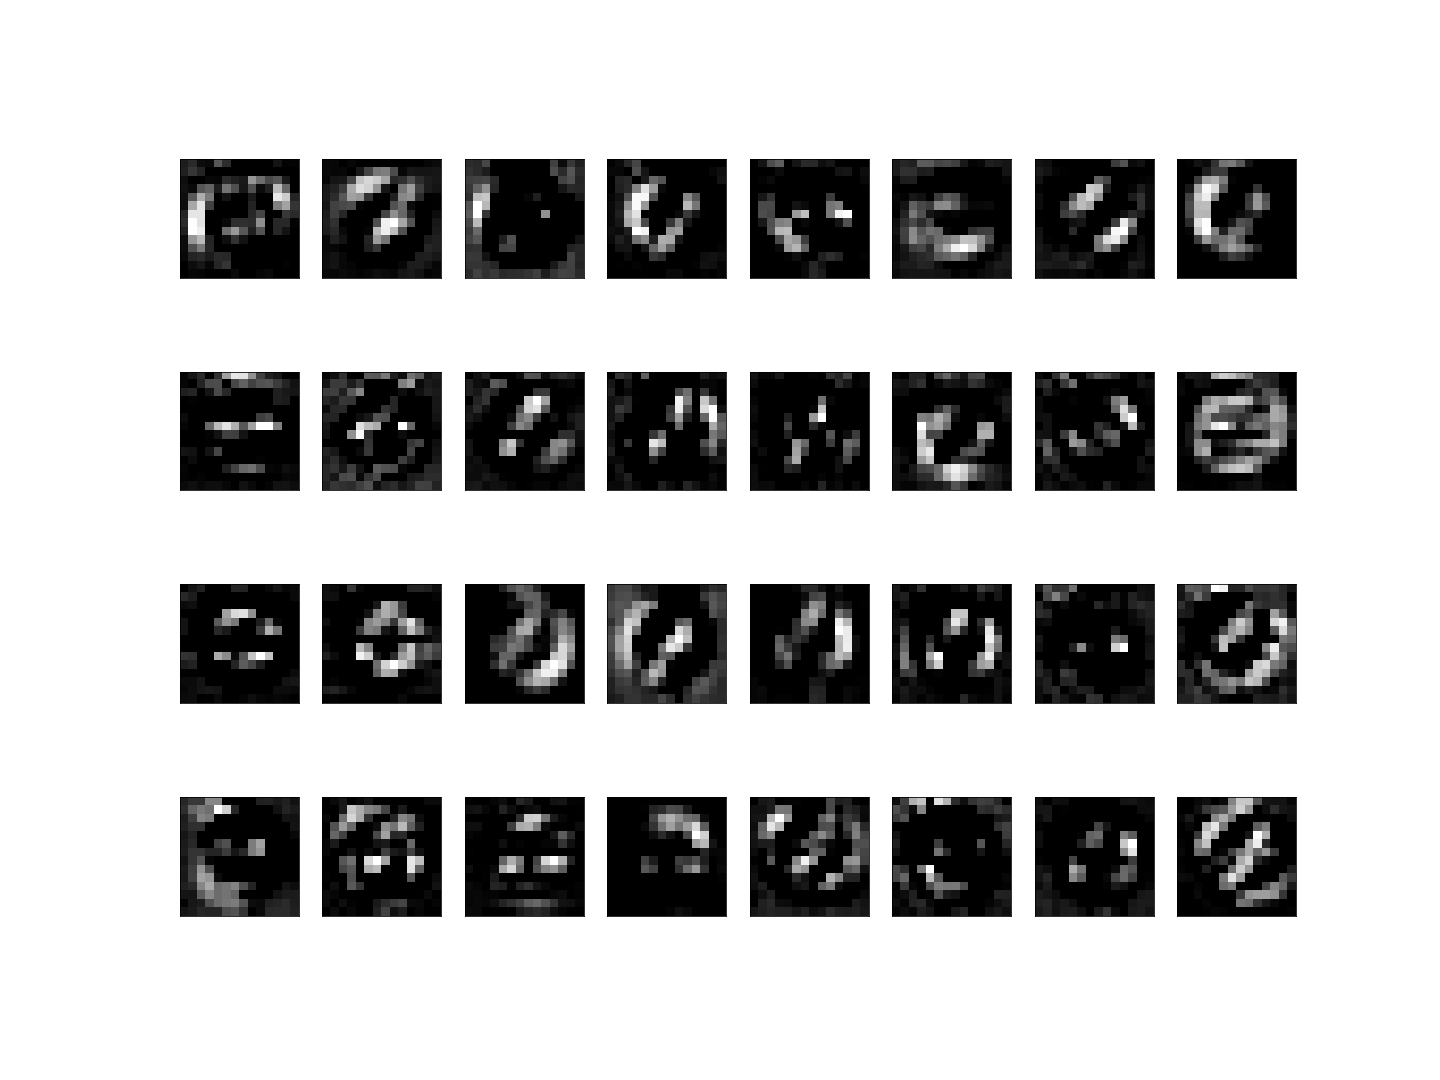

layer : Conv3_3 , feature map shape : (1, 14, 14, 64)
nrow : 8 , ncol : 8


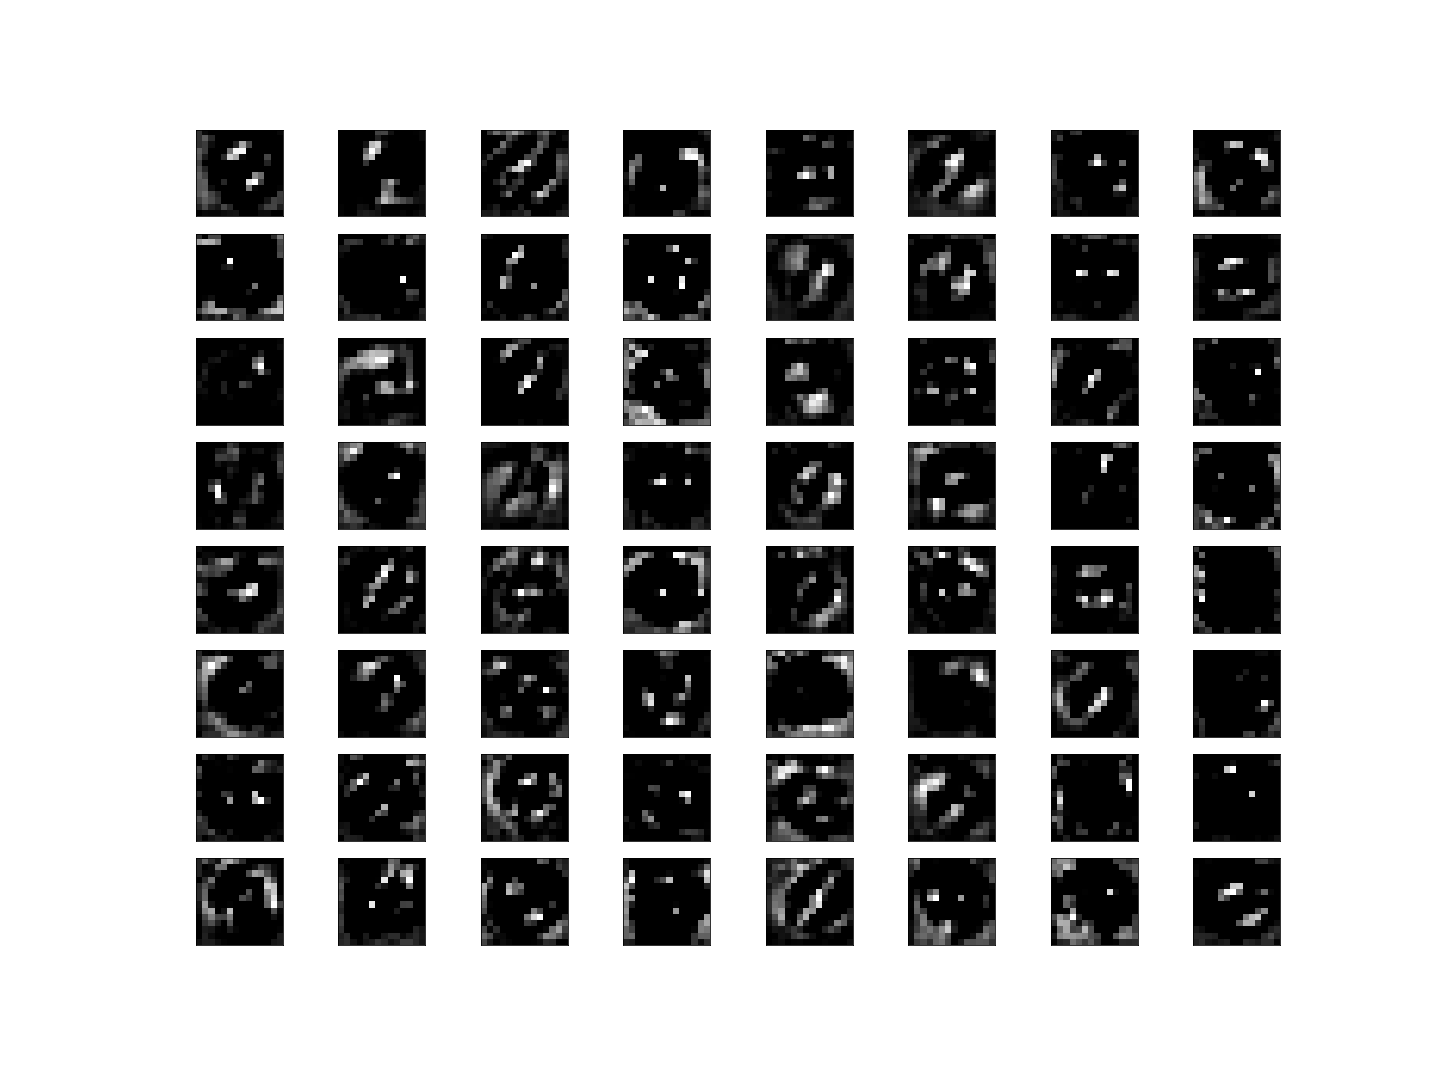

layer : Bnorm3 , feature map shape : (1, 14, 14, 64)
nrow : 8 , ncol : 8


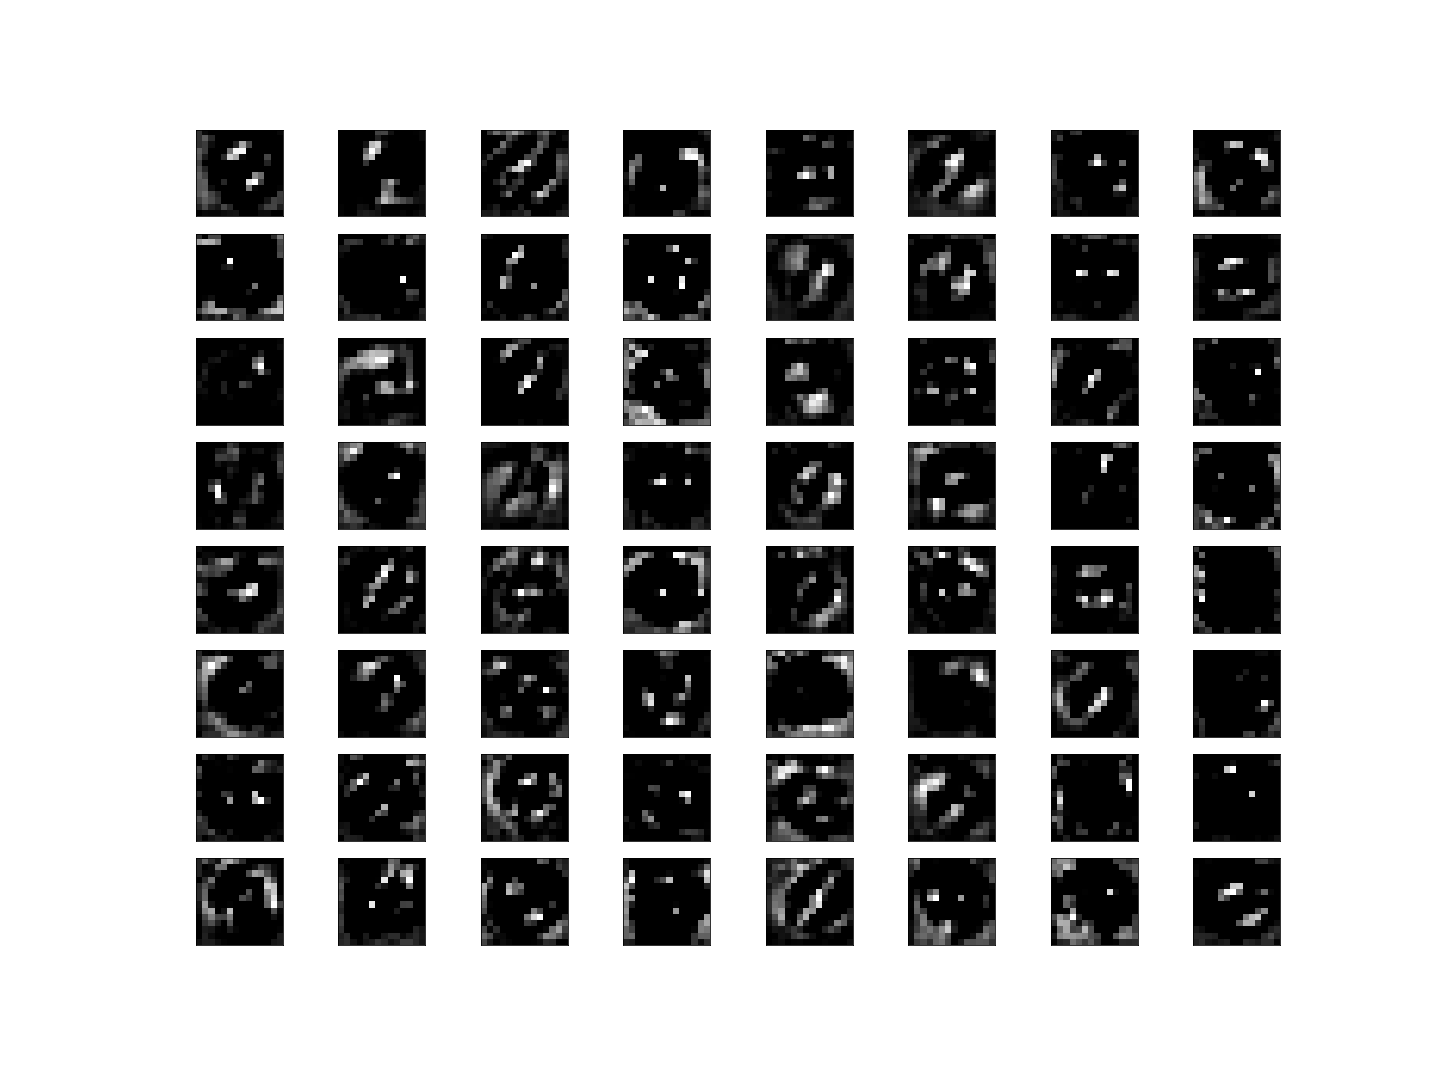

layer : Conv4_3 , feature map shape : (1, 14, 14, 64)
nrow : 8 , ncol : 8


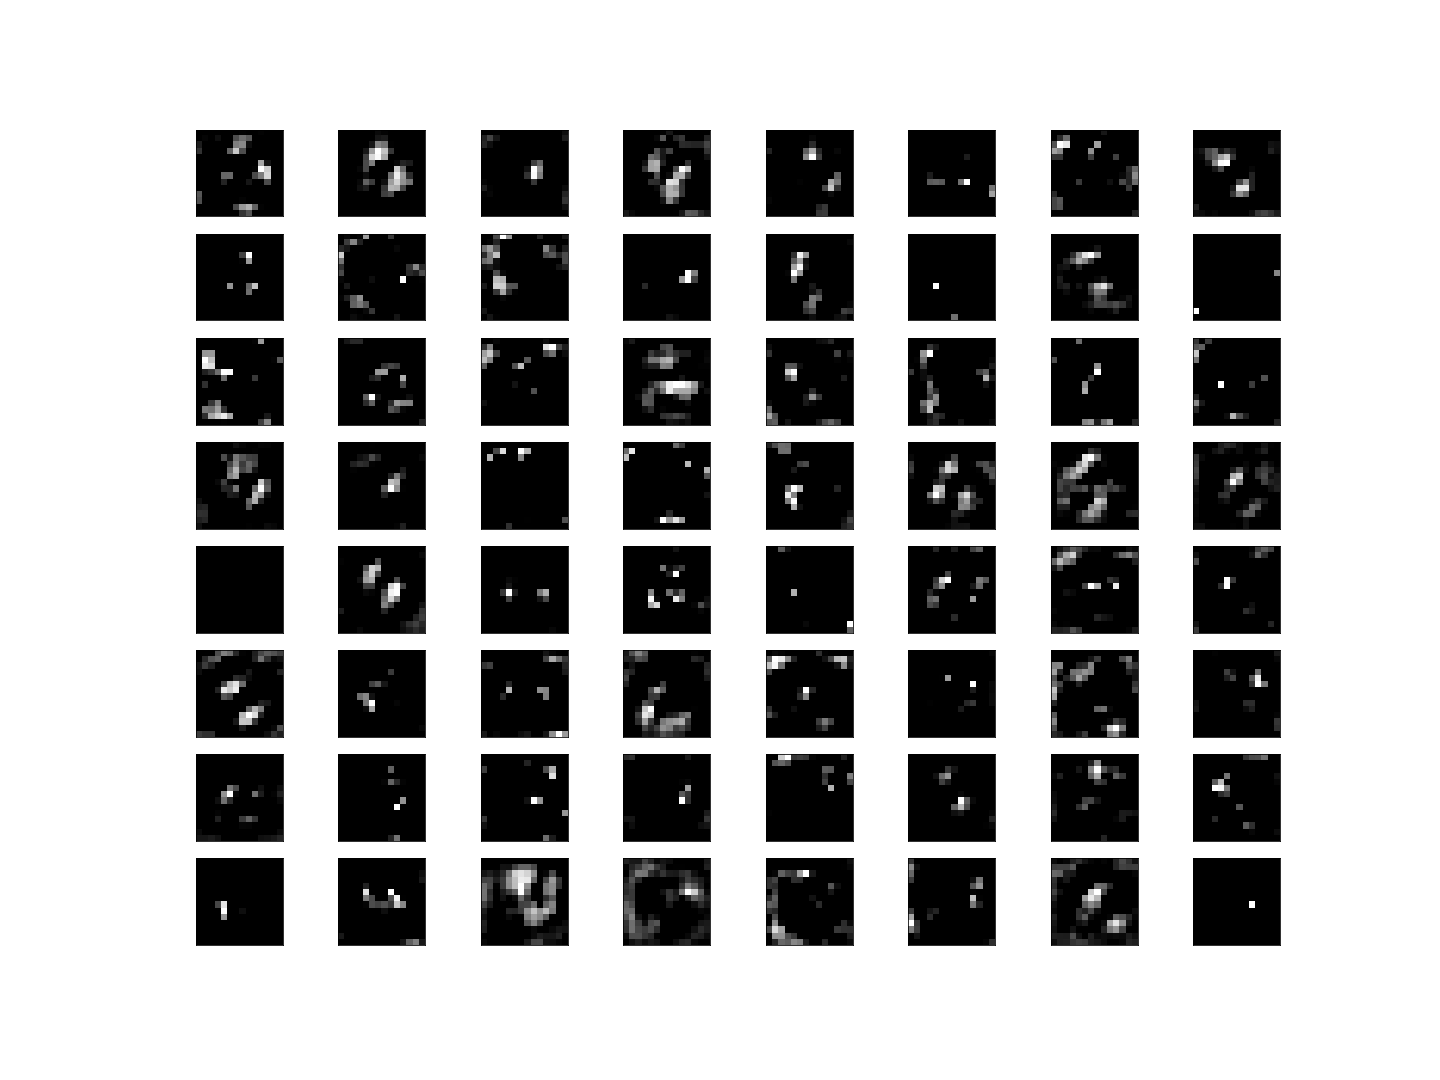

layer : Bnorm4 , feature map shape : (1, 14, 14, 64)
nrow : 8 , ncol : 8


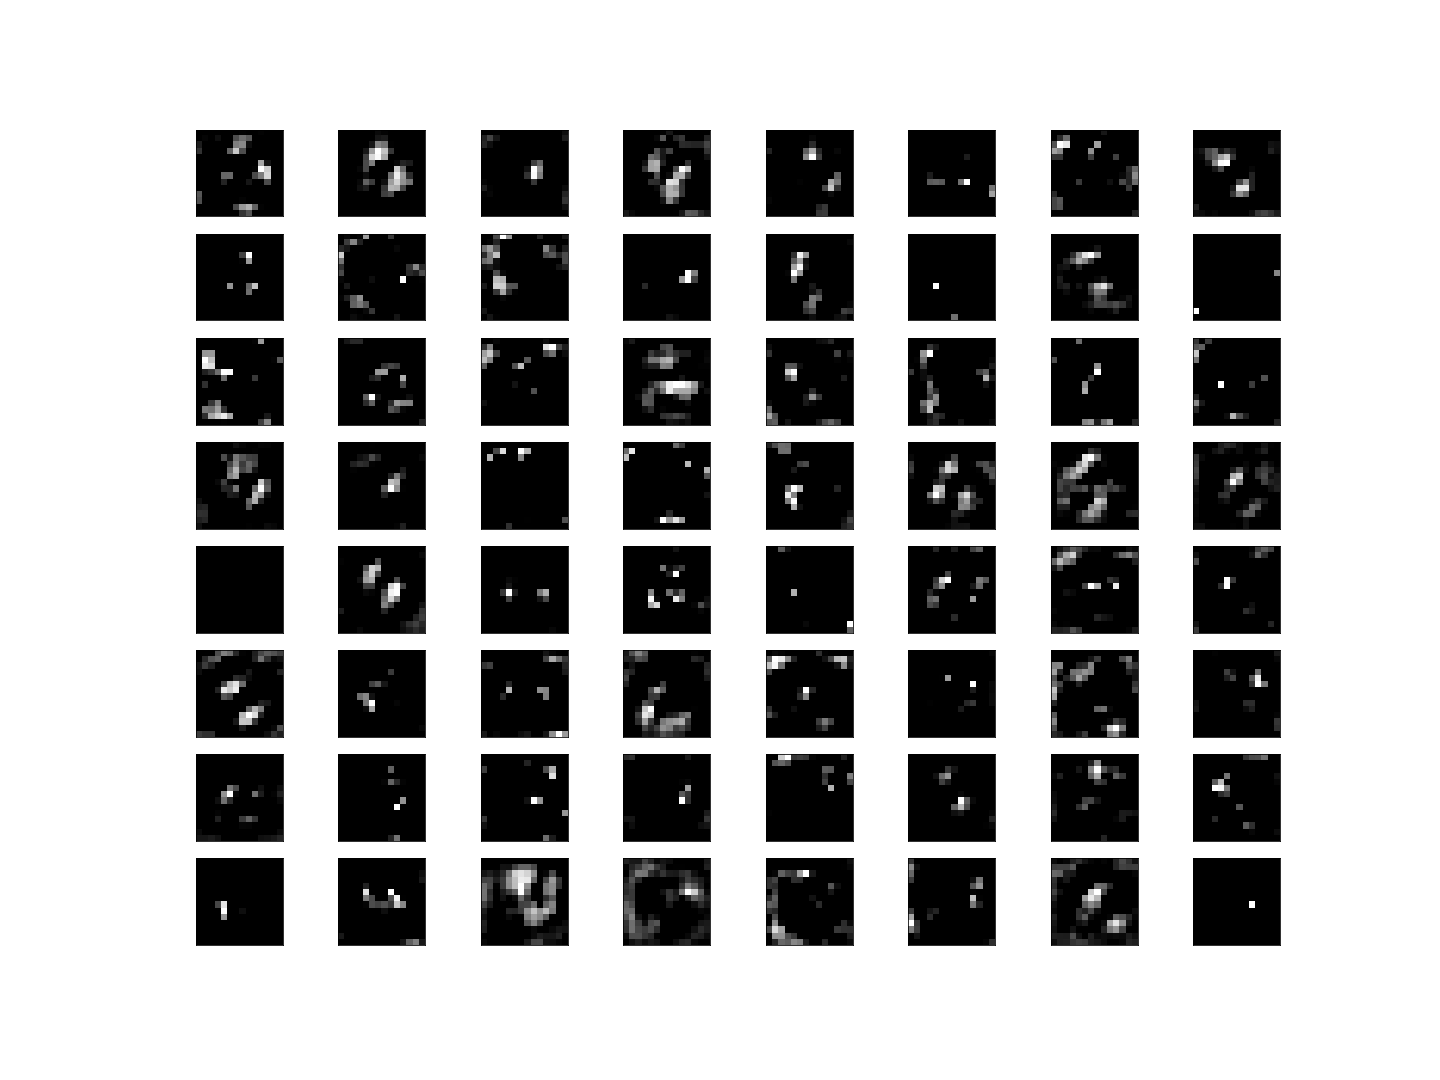

layer : AvgPool1 , feature map shape : (1, 7, 7, 64)
nrow : 8 , ncol : 8


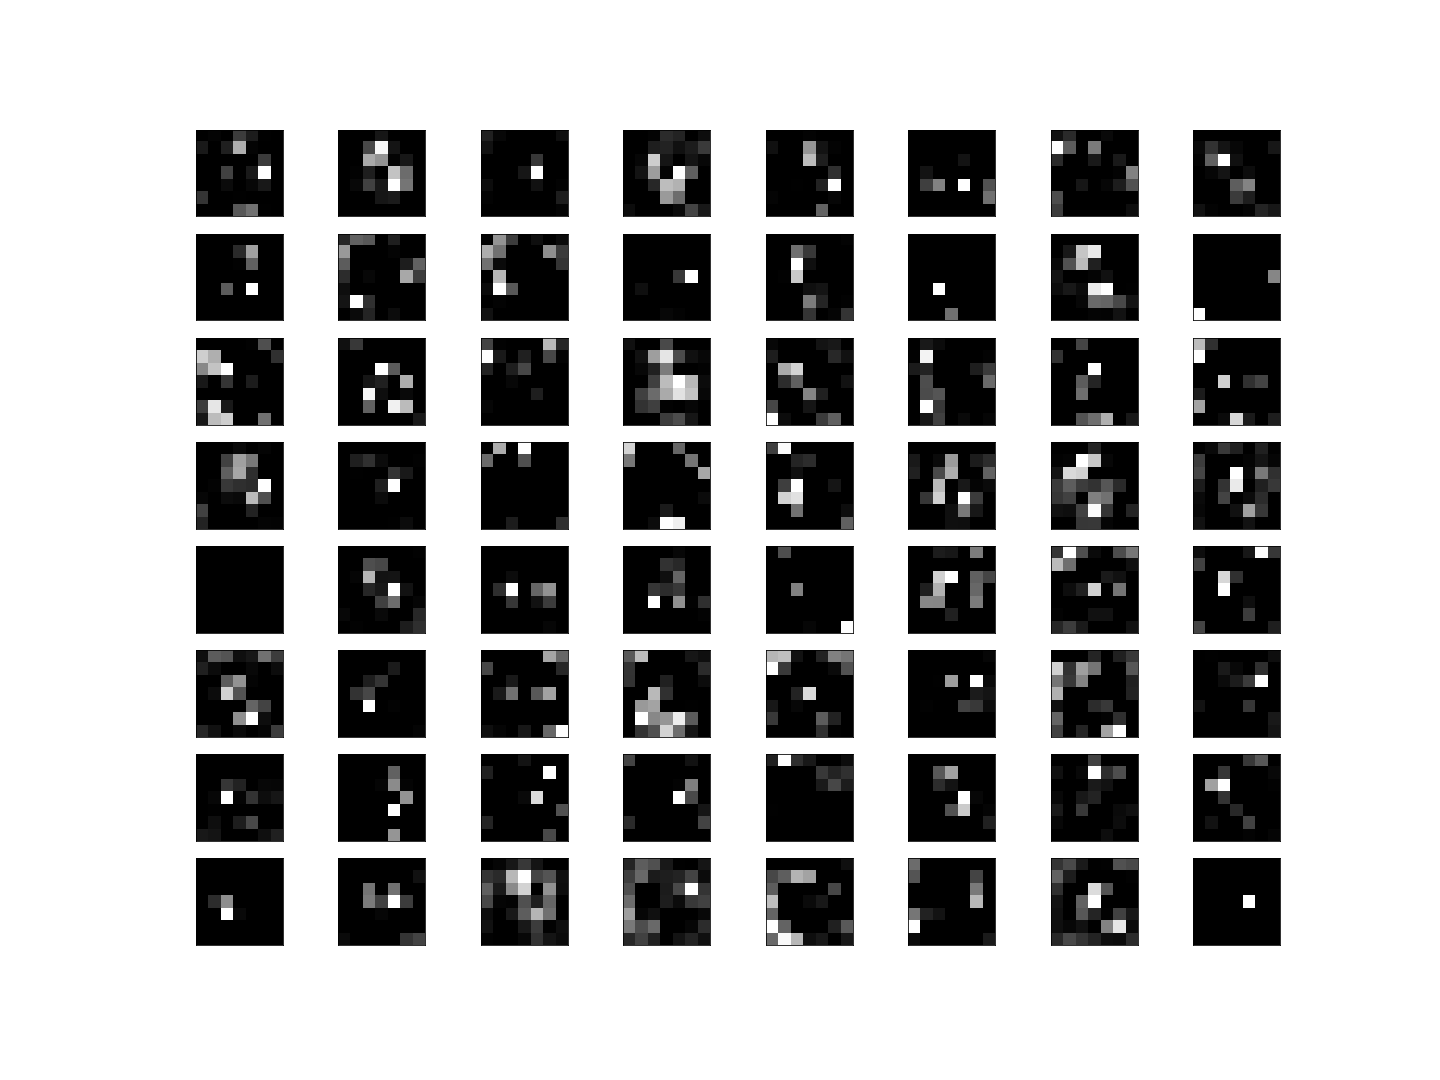

layer : Conv5_1 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


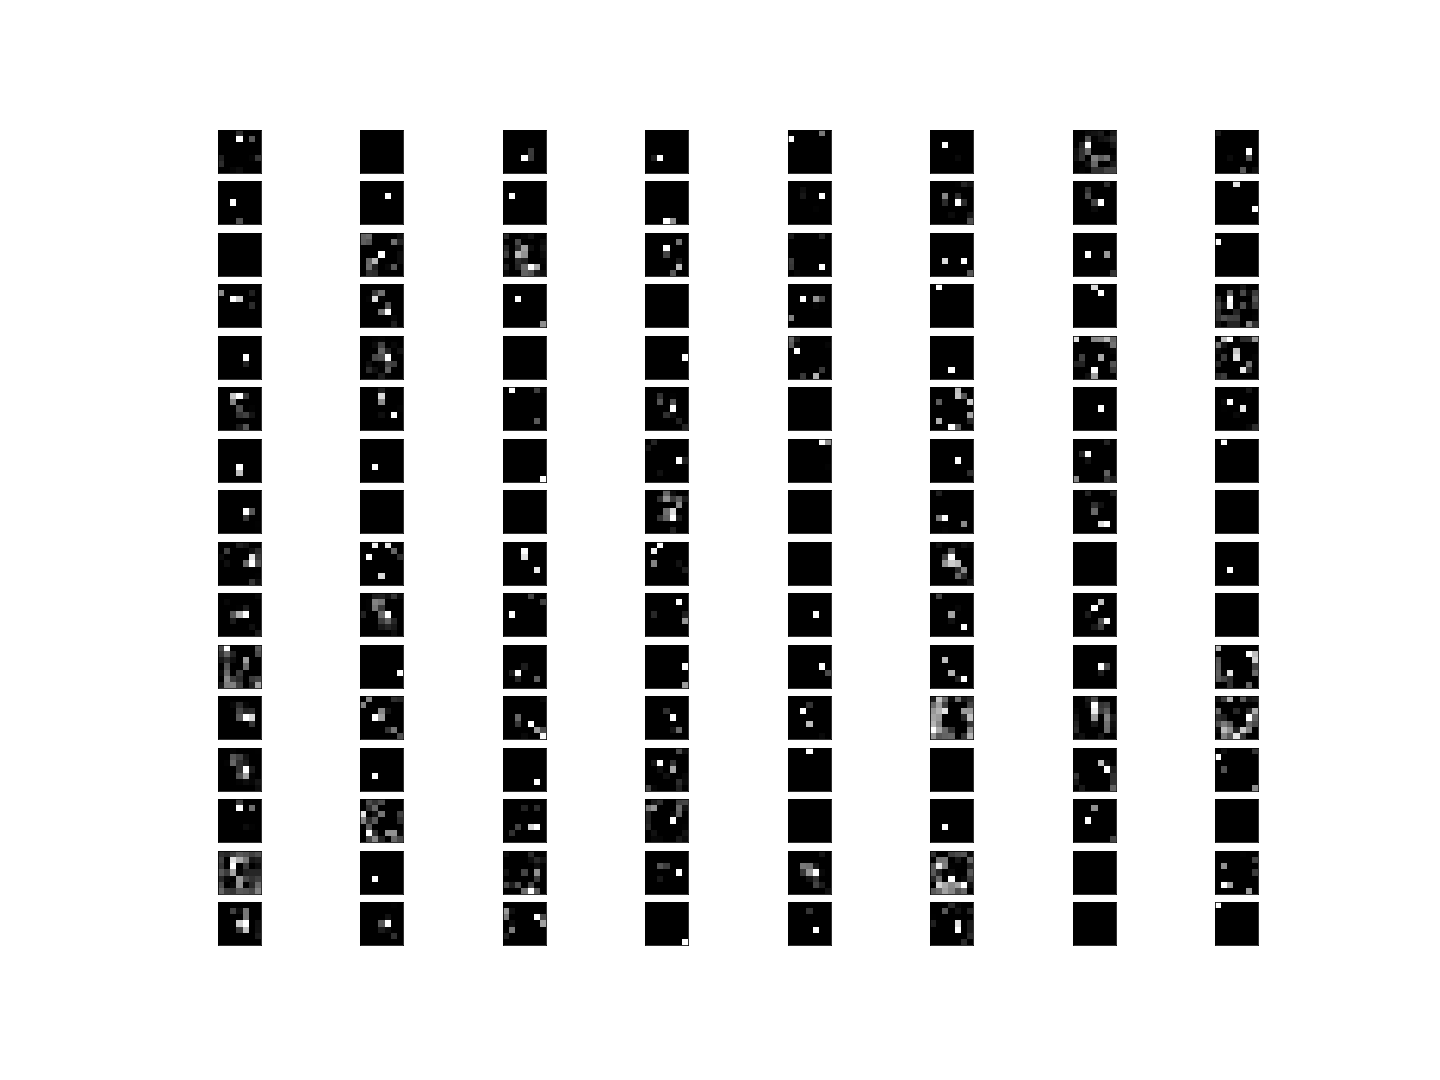

layer : Bnorm5 , feature map shape : (1, 7, 7, 128)
nrow : 16 , ncol : 8


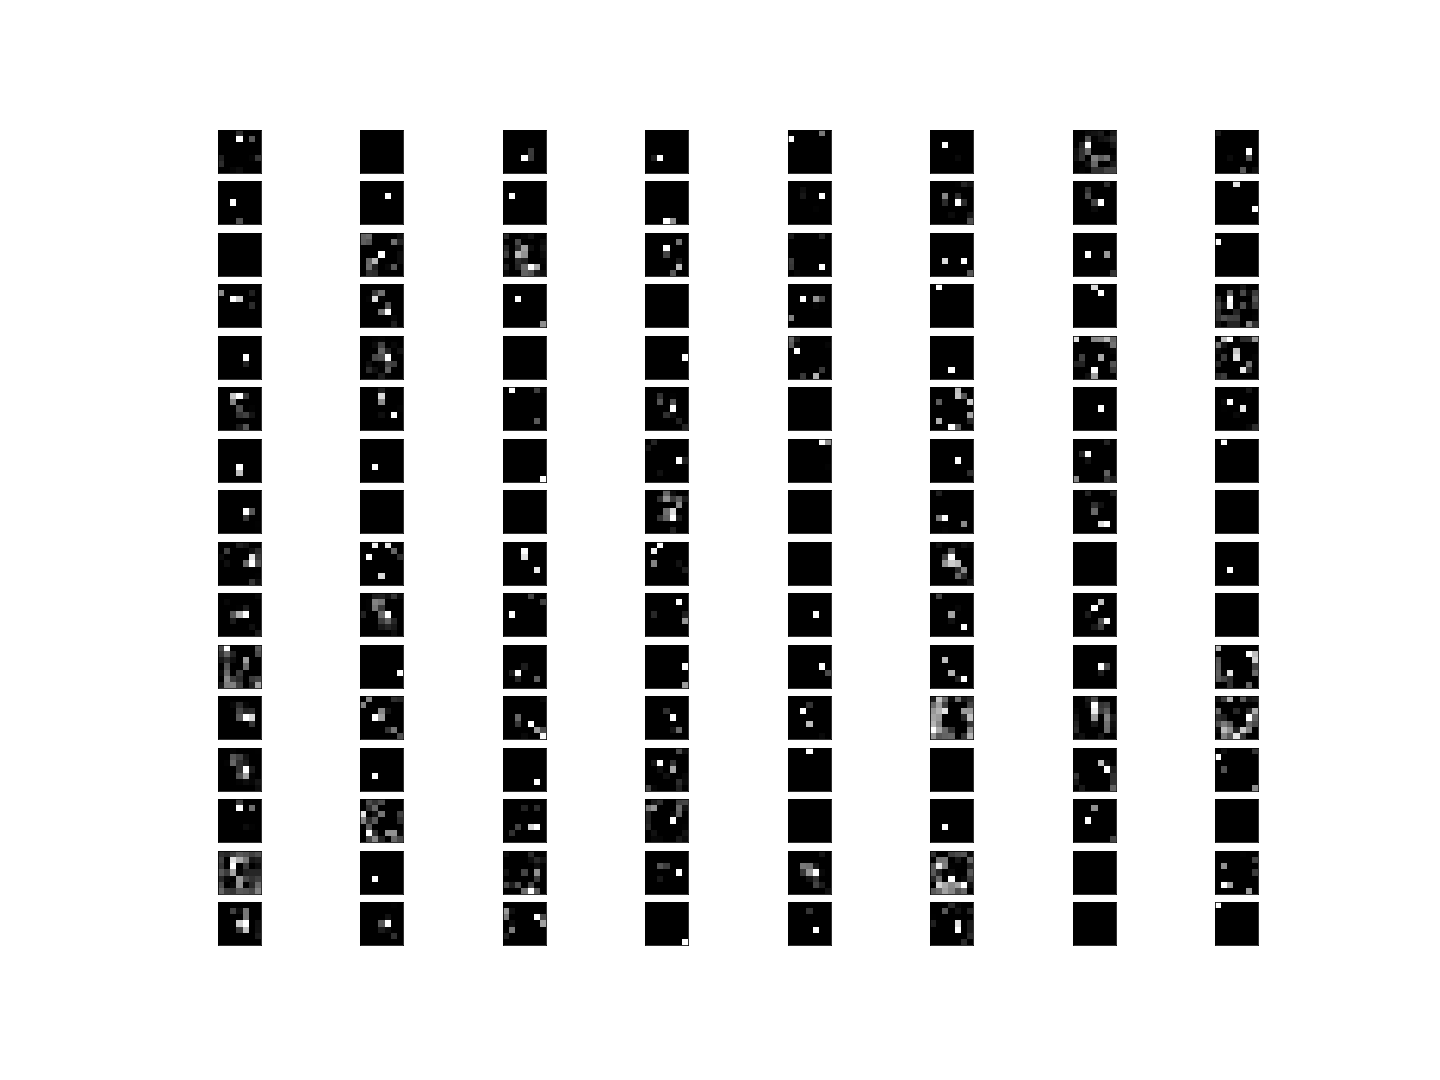

In [212]:
for n_layer in range(1,14):
  model_layer = Model(inputs=grayscale_model.inputs, outputs=grayscale_model.layers[n_layer].output)
  feature_maps = model_layer.predict(x_trn[1].reshape(1,32,32,3))
  print('layer : {} , feature map shape : {}'.format(grayscale_model.layers[n_layer].name,feature_maps.shape))

  n_row = int(feature_maps.shape[-1]/8)
  n_col = 8
  print('nrow : {} , ncol : {}'.format(n_row,n_col))
  plt.figure(figsize=(20,15))
  # plot all 32 maps in an 8x4 squares
  ix = 1
  for _ in range(n_row):
    for _ in range(n_col):
      # specify subplot and turn of axis
      ax = plt.subplot(n_row, n_col, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
      ix += 1
  # show the figure
  plt.show()

## Output of other layers

layer : dense_15 , feature map shape : (1, 32)


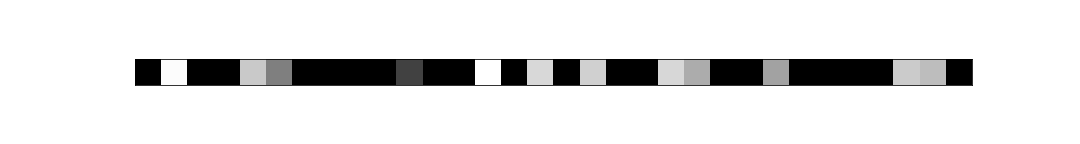

layer : dropout_5 , feature map shape : (1, 32)


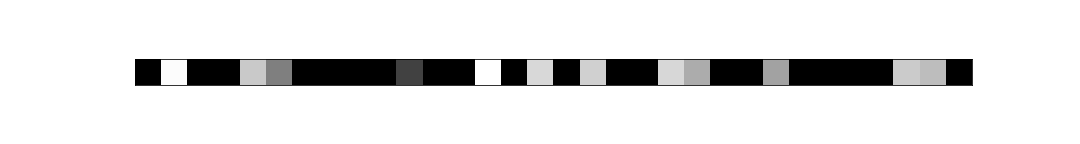

layer : batch_normalization_15 , feature map shape : (1, 32)


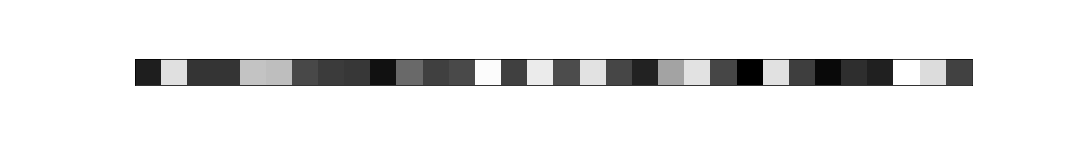

layer : dense_16 , feature map shape : (1, 20)


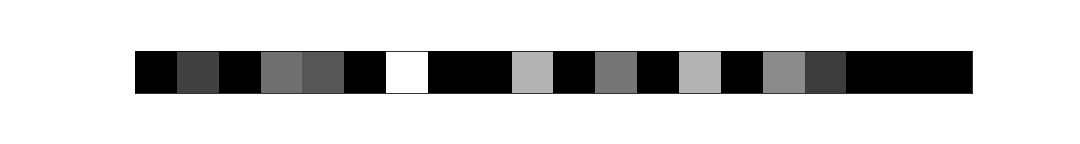

layer : batch_normalization_16 , feature map shape : (1, 20)


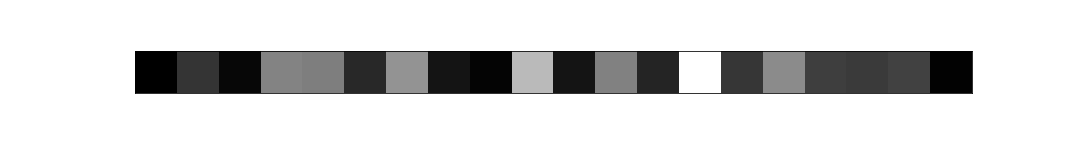

layer : dense_17 , feature map shape : (1, 15)


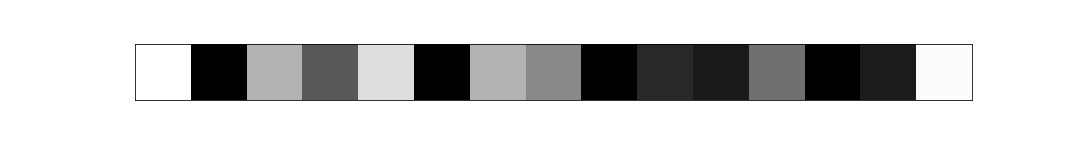

layer : batch_normalization_17 , feature map shape : (1, 15)


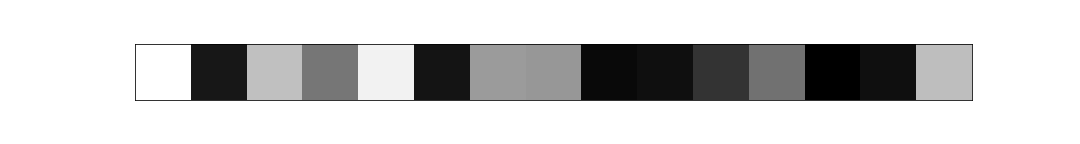

layer : preds , feature map shape : (1, 43)


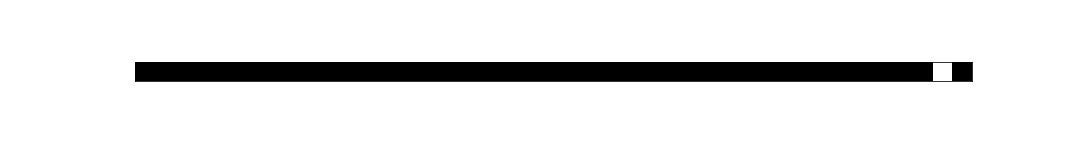

In [221]:
for n_layer in range(15,len(layer_names)):
  model_layer = Model(inputs=grayscale_model.inputs, outputs=grayscale_model.layers[n_layer].output)
  feature_maps = model_layer.predict(x_trn[1].reshape(1,32,32,3))
  print('layer : {} , feature map shape : {}'.format(grayscale_model.layers[n_layer].name,feature_maps.shape))

  plt.figure(figsize=(15,2))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(feature_maps, cmap='gray')
  # show the figure
  plt.show()